In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("car_price_prediction.csv")


In [ ]:
# preprocessing part 1 

data.drop_duplicates(inplace= True)

# doors and ID are not important for predicting price so we can drop them
data = data.drop(["ID", "Doors"], axis=1)

# changing levy to float and filling missing values with median
data['Levy'] = data['Levy'].replace('-', np.nan).astype(float)
data['Levy'].fillna(data['Levy'].median(), inplace=True)

# changing age of car to current year - production year
current_date = dt.datetime.now()
data["Age"] = current_date.year - data["Prod. year"]
data = data.drop("Prod. year", axis=1)

data['Cylinders'] = data['Cylinders'].astype(int)

# removing km from mileage and converting it to int
data["Mileage"] = data["Mileage"].str.replace("km", "")
data.Mileage = data.Mileage.astype("Int64")

# removing turbo from engine volume and converting it to float
data["Engine volume"] = data["Engine volume"].str.replace("Turbo", "")
data["Engine volume"] = data["Engine volume"].astype("float64")

# color dosent have any impact on price so we can drop it
data = data.drop("Color",axis=1)

In [14]:
# outlier treament

numeric_data = data.select_dtypes(exclude=object)

# before
for col in numeric_data:
    fig, ax =plt.subplots(1,2, constrained_layout=True)
    fig.set_size_inches(10, 6)
    sns.distplot(data[col], ax=ax[0]).set(title="Distplot")
    sns.boxplot(data[col], ax=ax[1]).set(title="Boxplot")
    plt.suptitle(f'{col.title()} (Before handling outliers)',weight='bold')
    fig.show()

# counting
for col in numeric_data:
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iq = q3 - q1
    
    low = q1 - 1.5 * iq
    high = q3 + 1.5 * iq
    outlier = ((numeric_data[col] > high) | (numeric_data[col] < low)).sum()

    total = numeric_data[col].shape[0]
    print(f"Total Outliers in {col}: {outlier}, {round(100*(outlier)/total,2)}%")

# removing outliers
for col in numeric_data:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    
# after
for col in numeric_data:
    fig, ax =plt.subplots(1,2, constrained_layout=True)
    fig.set_size_inches(10, 6)
    sns.distplot(data[col], ax=ax[0]).set(title="Distplot")
    sns.boxplot(data[col], ax=ax[1]).set(title="Boxplot")
    plt.suptitle(f'{col.title()} (After handling outliers)',weight='bold')
    fig.show()

In [ ]:
# preprocessing part 2

# Log Transformation for skewed features
data['Price'] = np.log1p(data['Price'])
data['Mileage'] = np.log1p(data['Mileage'])
data['Levy'] = np.log1p(data['Levy'])

# Creating interaction features
data['Price_per_KM'] = data['Price'] / (data['Mileage'] + 1)
data['Engine_per_Cylinder'] = data['Engine volume'] / data['Cylinders']
data['Age*Mileage'] = data['Age'] * data['Mileage']

#label encoding and trainig
categorical_cols = ['Manufacturer', 'Category', 'Fuel type', 'Gear box type', 'Model', 'Leather interior', 'Wheel', 'Drive wheels']

# Apply One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
encoded_features = pd.DataFrame(ohe.fit_transform(data[categorical_cols]))

# Assign proper column names
encoded_features.columns = ohe.get_feature_names_out()

# Merge encoded features and drop original categorical columns
data = pd.concat([data, encoded_features], axis=1).drop(columns=categorical_cols)

# Ensure all columns are numeric
print("All columns are now numeric:", data.dtypes.unique())

data = data.dropna(subset=['Price'])

X = data.drop(columns=['Price'])
y = data['Price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure x_test has same columns as x_train (reindexing)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)    

Total Outliers in Price: 1055, 5.57%
Total Outliers in Levy: 3103, 16.4%
Total Outliers in Engine volume: 1358, 7.18%
Total Outliers in Mileage: 635, 3.36%
Total Outliers in Cylinders: 4765, 25.18%
Total Outliers in Airbags: 0, 0.0%
Total Outliers in Age: 962, 5.08%
All columns are now numeric: [dtype('float64')]


In [32]:
feature_names = list(X.columns)

In [4]:
# Step 6: Feature Scaling
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
# Step 7: Model Training & Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100],  
    'max_depth': [10, 20],      
    'min_samples_split': [2, 5] 
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_


In [ ]:
# stacking model
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

stack_model = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor(max_depth=10)),
        ('rf', RandomForestRegressor(n_estimators=100))
    ],
    final_estimator=HistGradientBoostingRegressor()
)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [20]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

# Handle missing values
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())

In [21]:
stack_model.fit(x_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('dt', DecisionTreeRegressor(max_depth=10)),
                              ('rf', RandomForestRegressor())],
                  final_estimator=HistGradientBoostingRegressor())

MAE: 0.02705289027412617
RMSE: 0.10239558329501561
R^2 Score: 0.9957743863166405


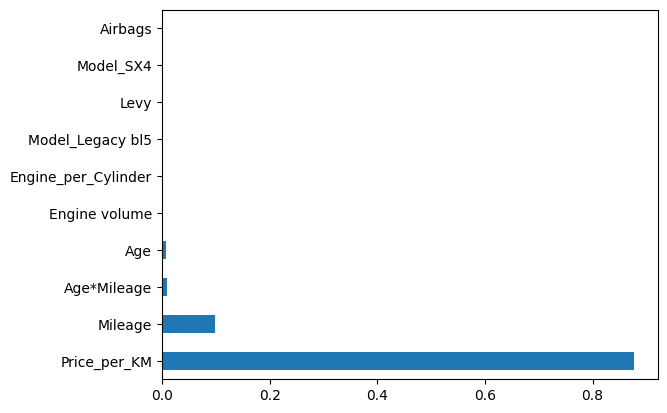

In [22]:
y_pred = stack_model.predict(x_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score:", r2_score(y_test, y_pred))

# Step 10: Feature Importance Analysis
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

In [33]:
import pickle

# Assuming 'stack_model' is your trained model
with open('stacked_model.pkl', 'wb') as f:
    pickle.dump(stack_model, f)

# Save MinMaxScaler
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save OneHotEncoder
with open('onehot_encoder.pkl', 'wb') as f:
    pickle.dump(ohe, f)
    
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

In [36]:
class CarPricePredictor:
    def __init__(self, model_path='stacked_model.pkl', 
                 scaler_path='minmax_scaler.pkl', 
                 encoder_path='onehot_encoder.pkl',
                 feature_names_path='feature_names.pkl'):
        """
        Initialize predictor with saved model, scaler, and encoder
        """
        # Load stacked model
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        
        # Load scaler
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        
        # Load one-hot encoder
        with open(encoder_path, 'rb') as f:
            self.encoder = pickle.load(f)
            
        with open(feature_names_path, 'rb') as f:
            self.feature_names = pickle.load(f)
        
        # Categorical columns that were one-hot encoded
        self.categorical_cols = [
            'Manufacturer', 'Category', 'Fuel type', 
            'Gear box type', 'Model', 'Leather interior', 
            'Wheel', 'Drive wheels'
        ]

    def preprocess_input(self, input_data):
        """
        Preprocess single input for prediction
        """
        # Create DataFrame
        df = pd.DataFrame([input_data])
        
        # Replace missing values/handle special cases (like in original preprocessing)
        df['Levy'] = df['Levy'].replace('-', np.nan).astype(float)
        df['Levy'] = df['Levy'].fillna(df['Levy'].median())
        
        # Calculate Age
        current_date = dt.datetime.now()
        df["Age"] = current_date.year - df["Prod. year"]
        df = df.drop("Prod. year", axis=1)
        
        # Clean and convert numeric columns
        df['Cylinders'] = df['Cylinders'].astype(int)
        df["Mileage"] = df["Mileage"].str.replace("km", "").astype("Int64")
        df["Engine volume"] = df["Engine volume"].str.replace("Turbo", "").astype("float64")
        
        # Log transformations
        df['Mileage'] = np.log1p(df['Mileage'])
        df['Levy'] = np.log1p(df['Levy'])
        
        # Create interaction features
        df['Price_per_KM'] = 0 / (df['Mileage'] + 1)  # Placeholder, adjust as needed
        df['Engine_per_Cylinder'] = df['Engine volume'] / df['Cylinders']
        df['Age*Mileage'] = df['Age'] * df['Mileage']
        
        # One-hot encoding for categorical columns
        encoded_features = pd.DataFrame(
            self.encoder.transform(df[self.categorical_cols]),
            columns=self.encoder.get_feature_names_out()
        )
        
        # Merge and drop original categorical columns
        processed_df = pd.concat([
            df.drop(columns=self.categorical_cols), 
            encoded_features
        ], axis=1)
        
        # Remove any columns not in training data
        processed_df = processed_df.reindex(columns=self.feature_names, fill_value=0)
        
        # Scale features
        processed_array = self.scaler.transform(processed_df)
        return processed_array

    def predict_price(self, input_data):
        """
        Predict price for a single car
        
        Args:
            input_data (dict): Dictionary of car features
        
        Returns:
            float: Predicted car price (inverse log transformation)
        """
        # Preprocess input
        processed_input = self.preprocess_input(input_data)
        
        # Predict (remember price was log-transformed)
        predicted_log_price = self.model.predict(processed_input)[0]
        predicted_price = np.expm1(predicted_log_price)
        
        return predicted_price

In [39]:
def main():
    predictor = CarPricePredictor()
    
    sample_car = {
        'Manufacturer': 'LEXUS',
        'Model': 'RX 450',
        'Prod. year': 2010,
        'Category': 'Jeep',
        'Fuel type': 'Hybrid',
        'Gear box type': 'Automatic',
        'Engine volume': '3.5',
        'Mileage': '186005 km',
        'Cylinders': 6,
        'Wheel': 'Left wheel',
        'Color': 'Silver',
        'Leather interior': 'Yes',
        'Drive wheels': '4x4',
        'Doors': 4,
        'Levy': '1399',
        'ID': '45654403',
        'Airbags': 12
    }
    
    predicted_price = predictor.predict_price(sample_car)
    print(f"Predicted Car Price: ${predicted_price:,f}")

if __name__ == "__main__":
    main()

Predicted Car Price: $8.047884
